In [10]:
import glob
import math
import os
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

## Constants

In [11]:
USE_COLUMNS = ['Countrycode', 'AirQualityStation', 'UnitOfMeasurement', 'Concentration', 'DatetimeBegin', 'DatetimeEnd', 'Validity', 'Verification']
SOURCE_PATH = '../datasources/aq/$pollutant_id$/'
FILE_NAMES_FILTER = "*.csv"
POLLUTANT_ID_PARAM = '$pollutant_id$'
METADATA_USE_COLUMNS = ['Countrycode', 'AirQualityStation', 'AirPollutantCode', 'Longitude', 'Latitude', 'Altitude', 'AirQualityStationType', 'AirQualityStationArea']
METADATA_SOURCE_PATH = '../datasources/aq/PanEuropean_metadata.csv'
POLLUTANTS_CODES = [7, 6001, 5, 10, 1, 8]
POLLUTANTS_CODES_NAMES = {7: "O3", 6001: "PM2.5", 5: "PM10", 10: "CO", 1: "SO2", 8: "NO2"}

In [4]:
country_code = 'NL'

## Loading multiple csv to one dataframe

In [12]:
df_list= list()

for pol_id in POLLUTANTS_CODES:
    df = pd.concat(map(lambda p: pd.read_csv(p, usecols=USE_COLUMNS), glob.glob(os.path.join(SOURCE_PATH.replace(POLLUTANT_ID_PARAM, str(pol_id)), FILE_NAMES_FILTER))))
    print(f'Pollutant: {pol_id}. Lines count: {df.shape[0]}')
    df_list.append(df)
print(df_list[0].dtypes)
df_list[0].head()

Pollutant: 7. Lines count: 367636
Pollutant: 6001. Lines count: 423406
Pollutant: 5. Lines count: 378057
Pollutant: 10. Lines count: 412885
Pollutant: 1. Lines count: 364123
Pollutant: 8. Lines count: 262920
Countrycode           object
AirQualityStation     object
Concentration        float64
UnitOfMeasurement     object
DatetimeBegin         object
DatetimeEnd           object
Validity               int64
Verification           int64
dtype: object


,Countrycode,AirQualityStation,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
0,NL,STA-NL00494,2.9,µg/m3,2013-09-19 23:00:00 +01:00,2013-09-20 00:00:00 +01:00,1,1
1,NL,STA-NL00494,4.8,µg/m3,2013-09-22 09:00:00 +01:00,2013-09-22 10:00:00 +01:00,1,1
2,NL,STA-NL00494,20.9,µg/m3,2013-09-23 01:00:00 +01:00,2013-09-23 02:00:00 +01:00,1,1
3,NL,STA-NL00494,NaN,µg/m3,2013-09-23 04:00:00 +01:00,2013-09-23 05:00:00 +01:00,-1,1
4,NL,STA-NL00494,6.4,µg/m3,2013-09-24 18:00:00 +01:00,2013-09-24 19:00:00 +01:00,1,1


## Dataframe general statistics

In [13]:
print(f'Pollutant: {POLLUTANTS_CODES_NAMES[POLLUTANTS_CODES[0]]}')
df_list[0].describe(include='all')

Pollutant: O3


,Countrycode,AirQualityStation,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
count,367636,367636,356997.000000,367636,367636,367636,367636.000000,367636.000000
unique,1,4,NaN,1,85694,85694,NaN,NaN
top,NL,STA-NL00301,NaN,µg/m3,2013-09-19 23:00:00 +01:00,2013-09-20 00:00:00 +01:00,NaN,NaN
freq,367636,94192,NaN,367636,8,8,NaN,NaN
mean,NaN,NaN,45.520474,NaN,NaN,NaN,0.959191,1.285364
std,NaN,NaN,26.517910,NaN,NaN,NaN,0.362159,0.699497
min,NaN,NaN,-141.900000,NaN,NaN,NaN,-1.000000,1.000000
25%,NaN,NaN,26.000000,NaN,NaN,NaN,1.000000,1.000000
50%,NaN,NaN,46.310000,NaN,NaN,NaN,1.000000,1.000000
75%,NaN,NaN,63.500000,NaN,NaN,NaN,1.000000,1.000000


## Missing values analysis

In [14]:
null_lines_count = sum(x['Concentration'].isna().sum() for x in df_list)
all_lines_count = sum(x.shape[0] for x in df_list)
print(f'Empty concentration: {round(null_lines_count/all_lines_count*100, 2)} %')

Empty concentration: 4.26 %


## Check that UnitOfMeasurement has one unique value then drop the column

In [15]:
for i in range(len(POLLUTANTS_CODES)):
    if df_list[i]['UnitOfMeasurement'].nunique() == 1:
       df_list[i].drop(columns= ['UnitOfMeasurement'], inplace=True)
    else:
        print(f'Pollutant: {POLLUTANTS_CODES[i]} - UnitOfMeasurement are not unique')

print(f'UnitOfMeasurement values are unique per AirPollutantCode, the columns were dropped')

UnitOfMeasurement values are unique per AirPollutantCode, the columns were dropped


## Exclude lines with missing, invalid and unverified values from dataframe. Then drop Verification and Validity columns

In [16]:
valid_lines_count = 0
for i in range(len(POLLUTANTS_CODES)):
    good_cond = ~df_list[i]['Concentration'].isna() & df_list[i]['Verification'].__eq__(1) & df_list[i]['Validity'].__gt__(0)
    df_list[i]= df_list[i][good_cond]
    valid_lines_count += df_list[i].shape[0]
    df_list[i].drop(columns=['Verification', 'Validity'], inplace=True)

print(f'Null, unverified and invalid lines has been deleted. Deleted lines percent is {round((all_lines_count - valid_lines_count)/all_lines_count*100, 2)} %')

Null, unverified and invalid lines has been deleted. Deleted lines percent is 18.06 %


/tmp/ipykernel_740510/1302035974.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[i].drop(columns=['Verification', 'Validity'], inplace=True)


## Confirm that the periods of measurement different from 1 hour don't exist. Then drop DatetimeBegin column

In [18]:
non_hour_lines_count = 0
for i in range(len(POLLUTANTS_CODES)):
    df_list[i]['DatetimeEnd'] = pd.to_datetime(df_list[i]['DatetimeEnd'])
    df_list[i]['DatetimeBegin'] = pd.to_datetime(df_list[i]['DatetimeBegin'])
    df_hour_dif = df_list[i][((df_list[i]['DatetimeEnd'] - df_list[i]['DatetimeBegin']).dt.total_seconds() != 3600) & ~df_list[i]['Concentration'].isna()]
    print(f'Pollutant: {POLLUTANTS_CODES[i]} - Non-hourly records: {df_hour_dif.shape[0]}')
    non_hour_lines_count += df_hour_dif.shape[0]

    if df_hour_dif is not None and df_hour_dif.shape[0] > 0:
        df_days_dif = df_hour_dif[((df_hour_dif['DatetimeEnd'] - df_hour_dif['DatetimeBegin']).dt.days != 1) & ~df_hour_dif['Concentration'].isna()]
        print(f'Check: percent of non-daily intervals in non-hourly intervals: {round(df_days_dif.shape[0]/df_hour_dif.shape[0]*100, 2)} %')
        if df_days_dif is not None and df_days_dif.shape[0] > 0:
            print(df_days_dif.head())

    good_cond = (df_list[i]['DatetimeEnd'] - df_list[i]['DatetimeBegin']).dt.total_seconds() == 3600
    df_list[i]= df_list[i][good_cond]
    df_list[i].drop(columns=['DatetimeBegin'], inplace=True)

print(f'Total check: percent of non-hourly intervals in dataset: {round(non_hour_lines_count/valid_lines_count*100, 2)} %. These line were removed. The column DatetimeBegin was dropped')

Pollutant: 7 - Non-hourly records: 0
Pollutant: 6001 - Non-hourly records: 362
Check: percent of non-daily intervals in non-hourly intervals: 0.0 %
Pollutant: 5 - Non-hourly records: 0
Pollutant: 10 - Non-hourly records: 0
Pollutant: 1 - Non-hourly records: 0


/tmp/ipykernel_740510/2176591156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[i]['DatetimeEnd'] = pd.to_datetime(df_list[i]['DatetimeEnd'])


Pollutant: 8 - Non-hourly records: 0
Total check: percent of non-hourly intervals in dataset: 0.02 %. These line were removed. The column DatetimeBegin was dropped


/tmp/ipykernel_740510/2176591156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[i]['DatetimeBegin'] = pd.to_datetime(df_list[i]['DatetimeBegin'])


## Analysis: check concentration distribution per stations

--------------------------------------------POLLUTANT O3--------------------------------------------

count    304542.000000
mean         44.551359
std          26.670005
min        -141.900000
25%          24.520000
50%          45.200000
75%          62.640000
max         278.960000
Name: Concentration, dtype: float64
['STA-NL00494' 'STA-NL00301' 'STA-NL00929' 'STA-NL00012']


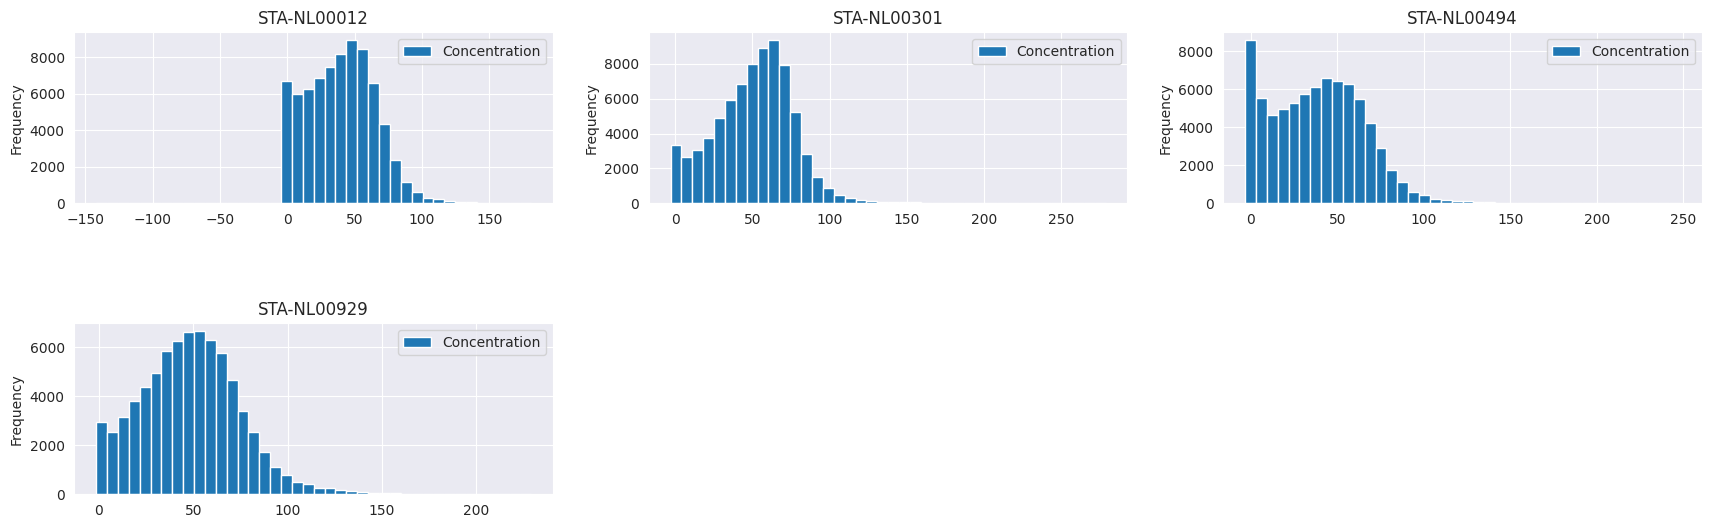

--------------------------------------------POLLUTANT PM2.5--------------------------------------------

count    304542.000000
mean         44.551359
std          26.670005
min        -141.900000
25%          24.520000
50%          45.200000
75%          62.640000
max         278.960000
Name: Concentration, dtype: float64
['STA-NL00494' 'STA-NL00301' 'STA-NL00929' 'STA-NL00012']


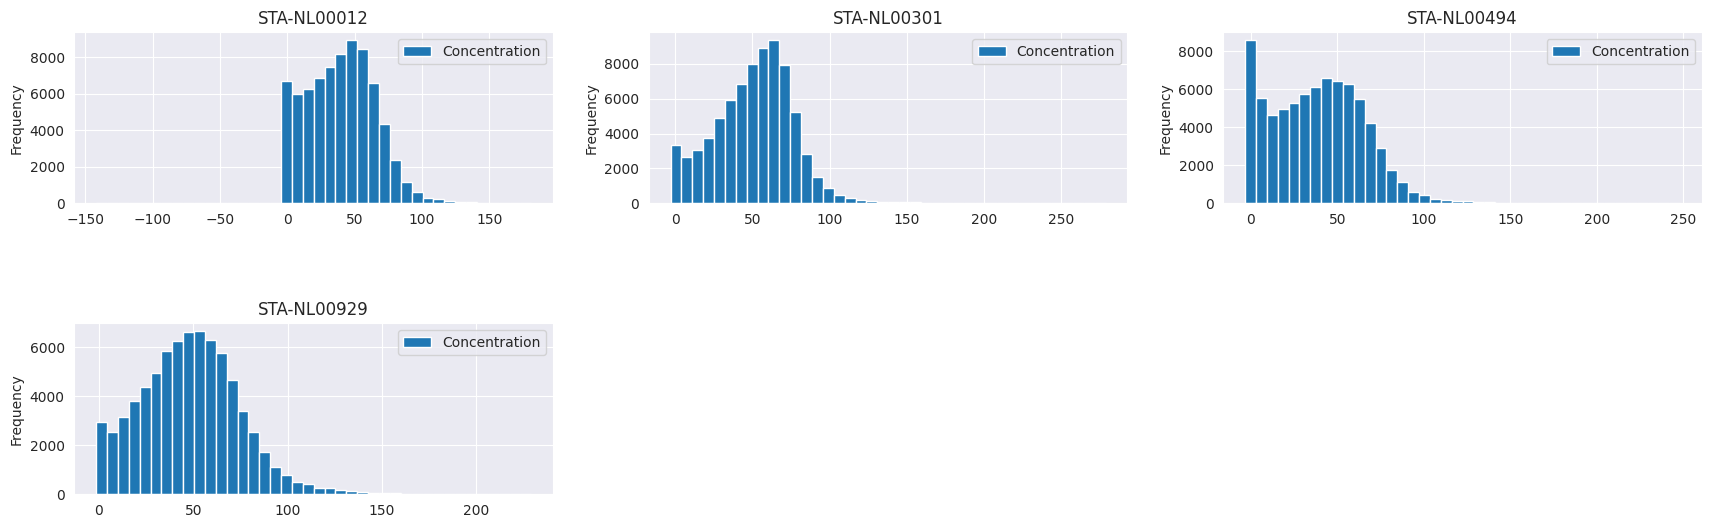

--------------------------------------------POLLUTANT PM10--------------------------------------------

count    304542.000000
mean         44.551359
std          26.670005
min        -141.900000
25%          24.520000
50%          45.200000
75%          62.640000
max         278.960000
Name: Concentration, dtype: float64
['STA-NL00494' 'STA-NL00301' 'STA-NL00929' 'STA-NL00012']


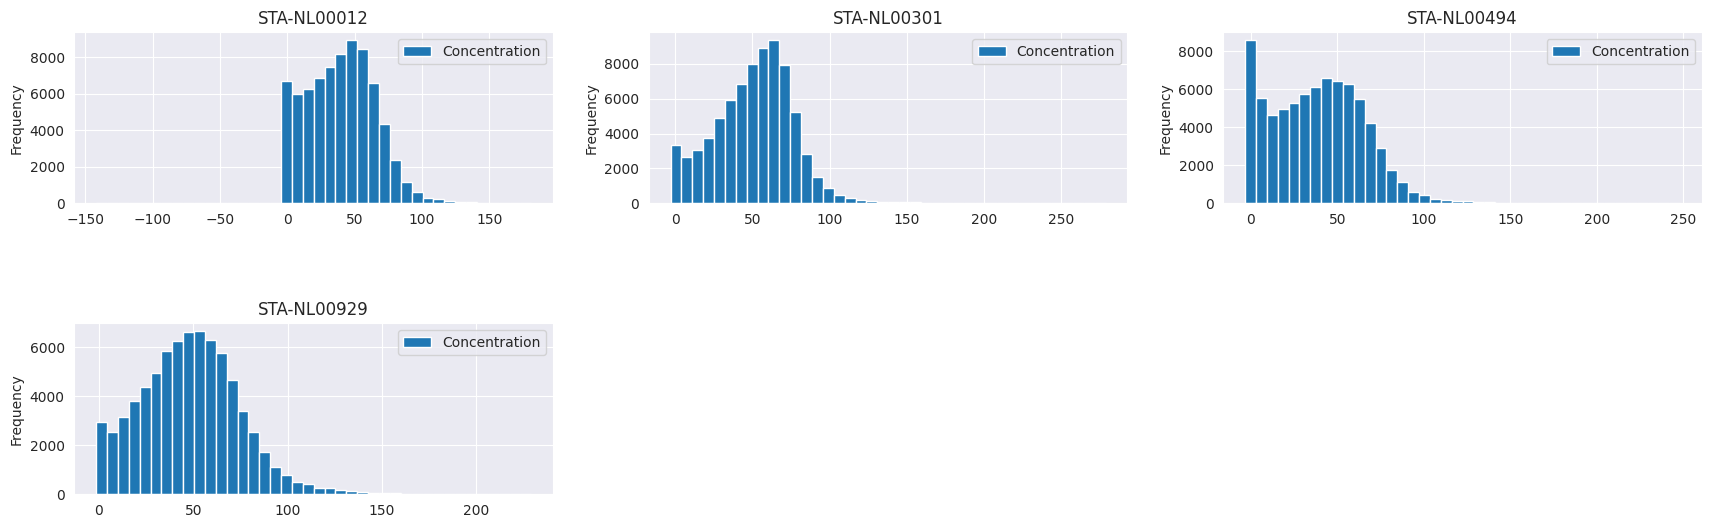

--------------------------------------------POLLUTANT CO--------------------------------------------

count    304542.000000
mean         44.551359
std          26.670005
min        -141.900000
25%          24.520000
50%          45.200000
75%          62.640000
max         278.960000
Name: Concentration, dtype: float64
['STA-NL00494' 'STA-NL00301' 'STA-NL00929' 'STA-NL00012']


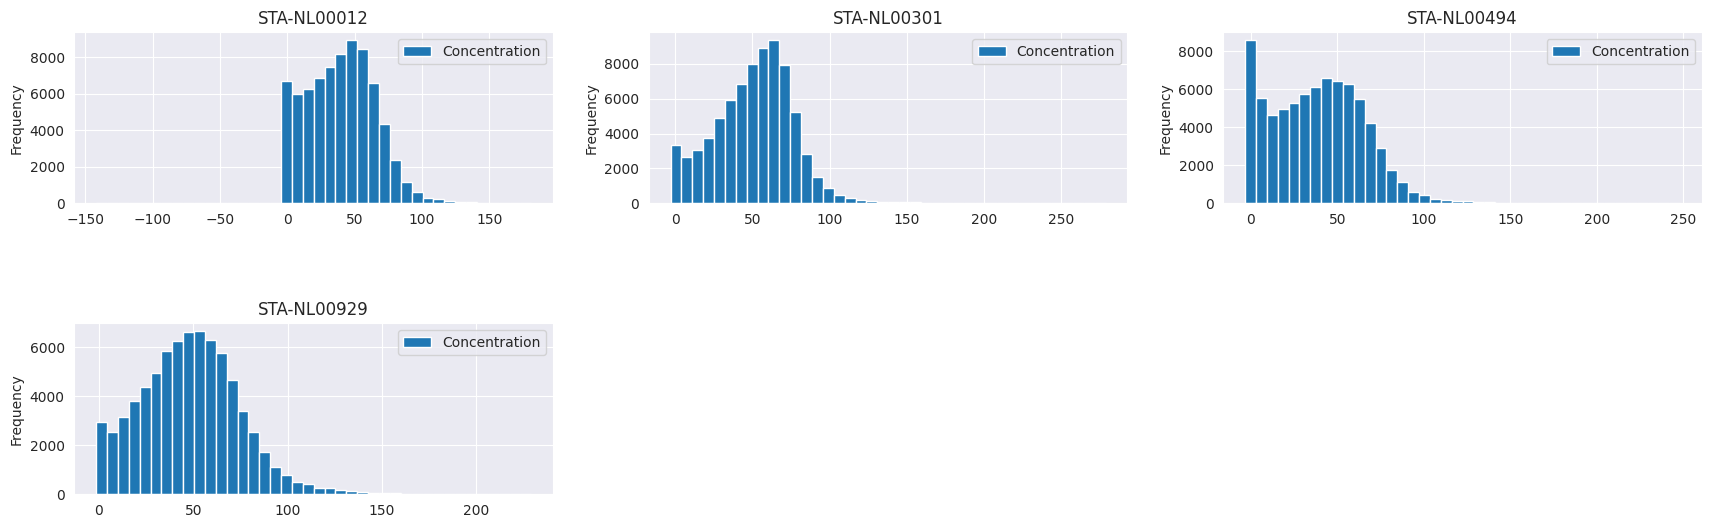

--------------------------------------------POLLUTANT SO2--------------------------------------------

count    304542.000000
mean         44.551359
std          26.670005
min        -141.900000
25%          24.520000
50%          45.200000
75%          62.640000
max         278.960000
Name: Concentration, dtype: float64
['STA-NL00494' 'STA-NL00301' 'STA-NL00929' 'STA-NL00012']


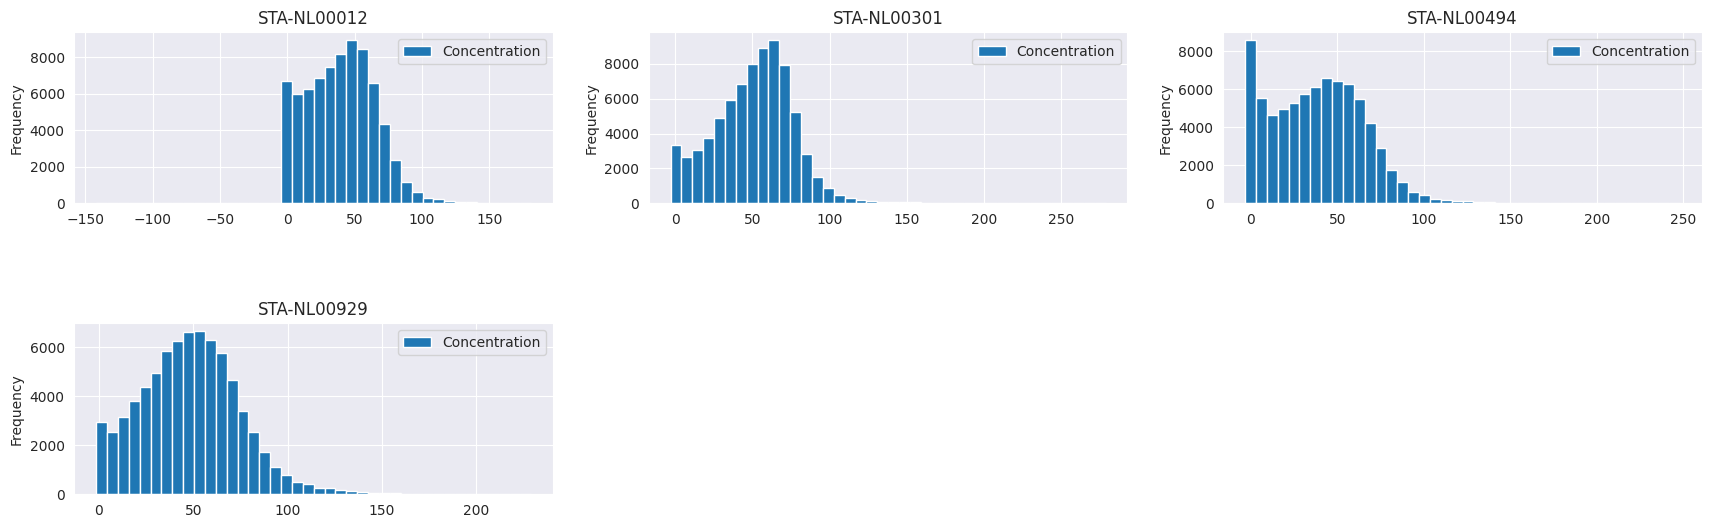

--------------------------------------------POLLUTANT NO2--------------------------------------------

count    304542.000000
mean         44.551359
std          26.670005
min        -141.900000
25%          24.520000
50%          45.200000
75%          62.640000
max         278.960000
Name: Concentration, dtype: float64
['STA-NL00494' 'STA-NL00301' 'STA-NL00929' 'STA-NL00012']


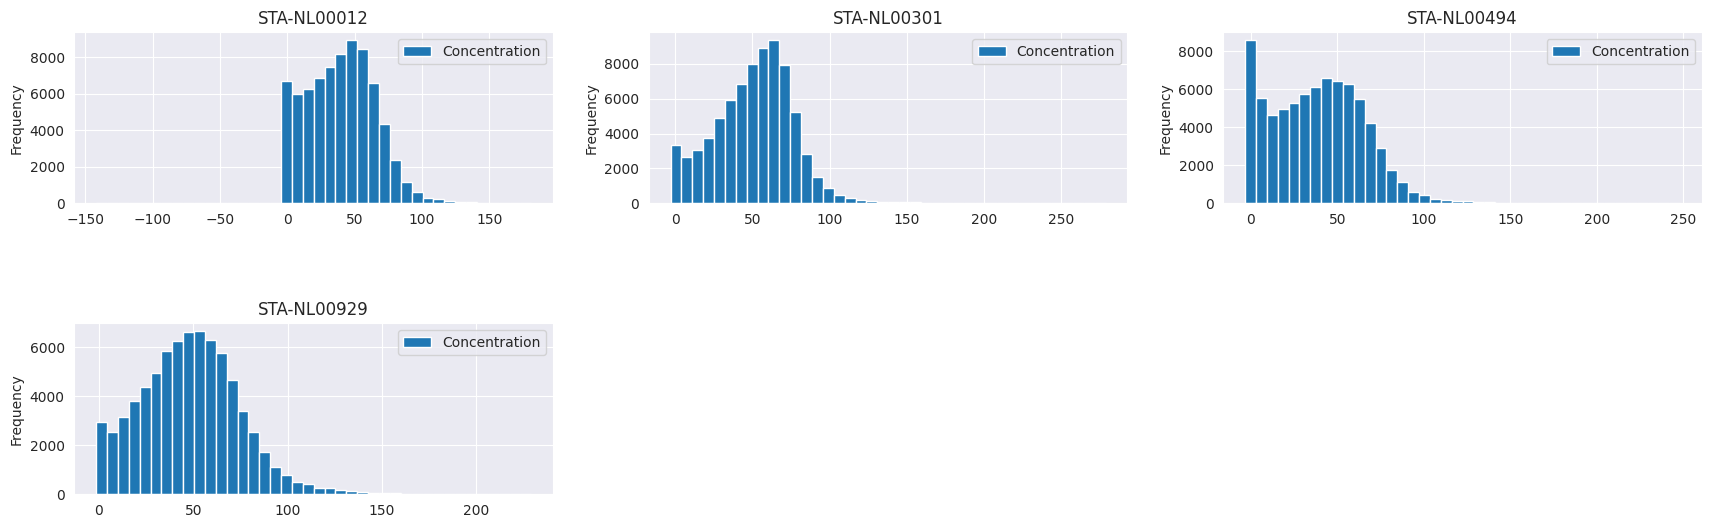

In [62]:
PLOTS_IN_LINE = 3

for i in range(len(POLLUTANTS_CODES)):
    print(f'--------------------------------------------POLLUTANT {POLLUTANTS_CODES_NAMES[POLLUTANTS_CODES[i]]}--------------------------------------------')
    print()
    print(df_list[0]['Concentration'].describe())
    stations = df_list[0]['AirQualityStation'].unique()
    print(stations)
    df_list[0].reset_index(inplace=True, drop=True)
    stations_count = df_list[0]['AirQualityStation'].nunique() + 1
    plots_lines_count = math.ceil(stations_count/PLOTS_IN_LINE)
    df_list[0].plot.hist(column=["Concentration"], by="AirQualityStation", figsize=(21, 3*plots_lines_count), bins=40, subplots=True, layout=(plots_lines_count, PLOTS_IN_LINE))
    plt.subplots_adjust(hspace=0.7)
    plt.show()

## Prepare dataframe for timeseries

In [64]:
df_mean_list = list()
for i in range(len(POLLUTANTS_CODES)):
    df_mean_list.append(df_list[i].groupby('DatetimeEnd')['Concentration'].mean().to_frame())
    df_mean_list[i] = df_mean_list[i].rename(columns={'Concentration': POLLUTANTS_CODES_NAMES[POLLUTANTS_CODES[i]]})

df_ts = reduce(lambda df1, df2: df1.merge(df2, how='outer', left_on=['DatetimeEnd'], right_on=['DatetimeEnd']), df_mean_list)
print(df_ts.shape[0])
df_ts.head()

70128


,O3,PM2.5,PM10,CO,SO2,NO2
DatetimeEnd,,,,,,
2013-01-01 01:00:00+01:00,47.6275,69.700,253.0812,0.3050,0.5025,27.836
2013-01-01 02:00:00+01:00,50.2325,31.700,47.7852,0.3316,0.9000,21.876
2013-01-01 03:00:00+01:00,50.9900,15.025,19.6252,0.3174,0.5200,23.414
2013-01-01 04:00:00+01:00,54.0800,12.700,11.4028,0.3198,0.6750,25.252
2013-01-01 05:00:00+01:00,49.4625,7.400,8.7172,0.2964,0.6875,19.440


## Timeseries for different pollutants

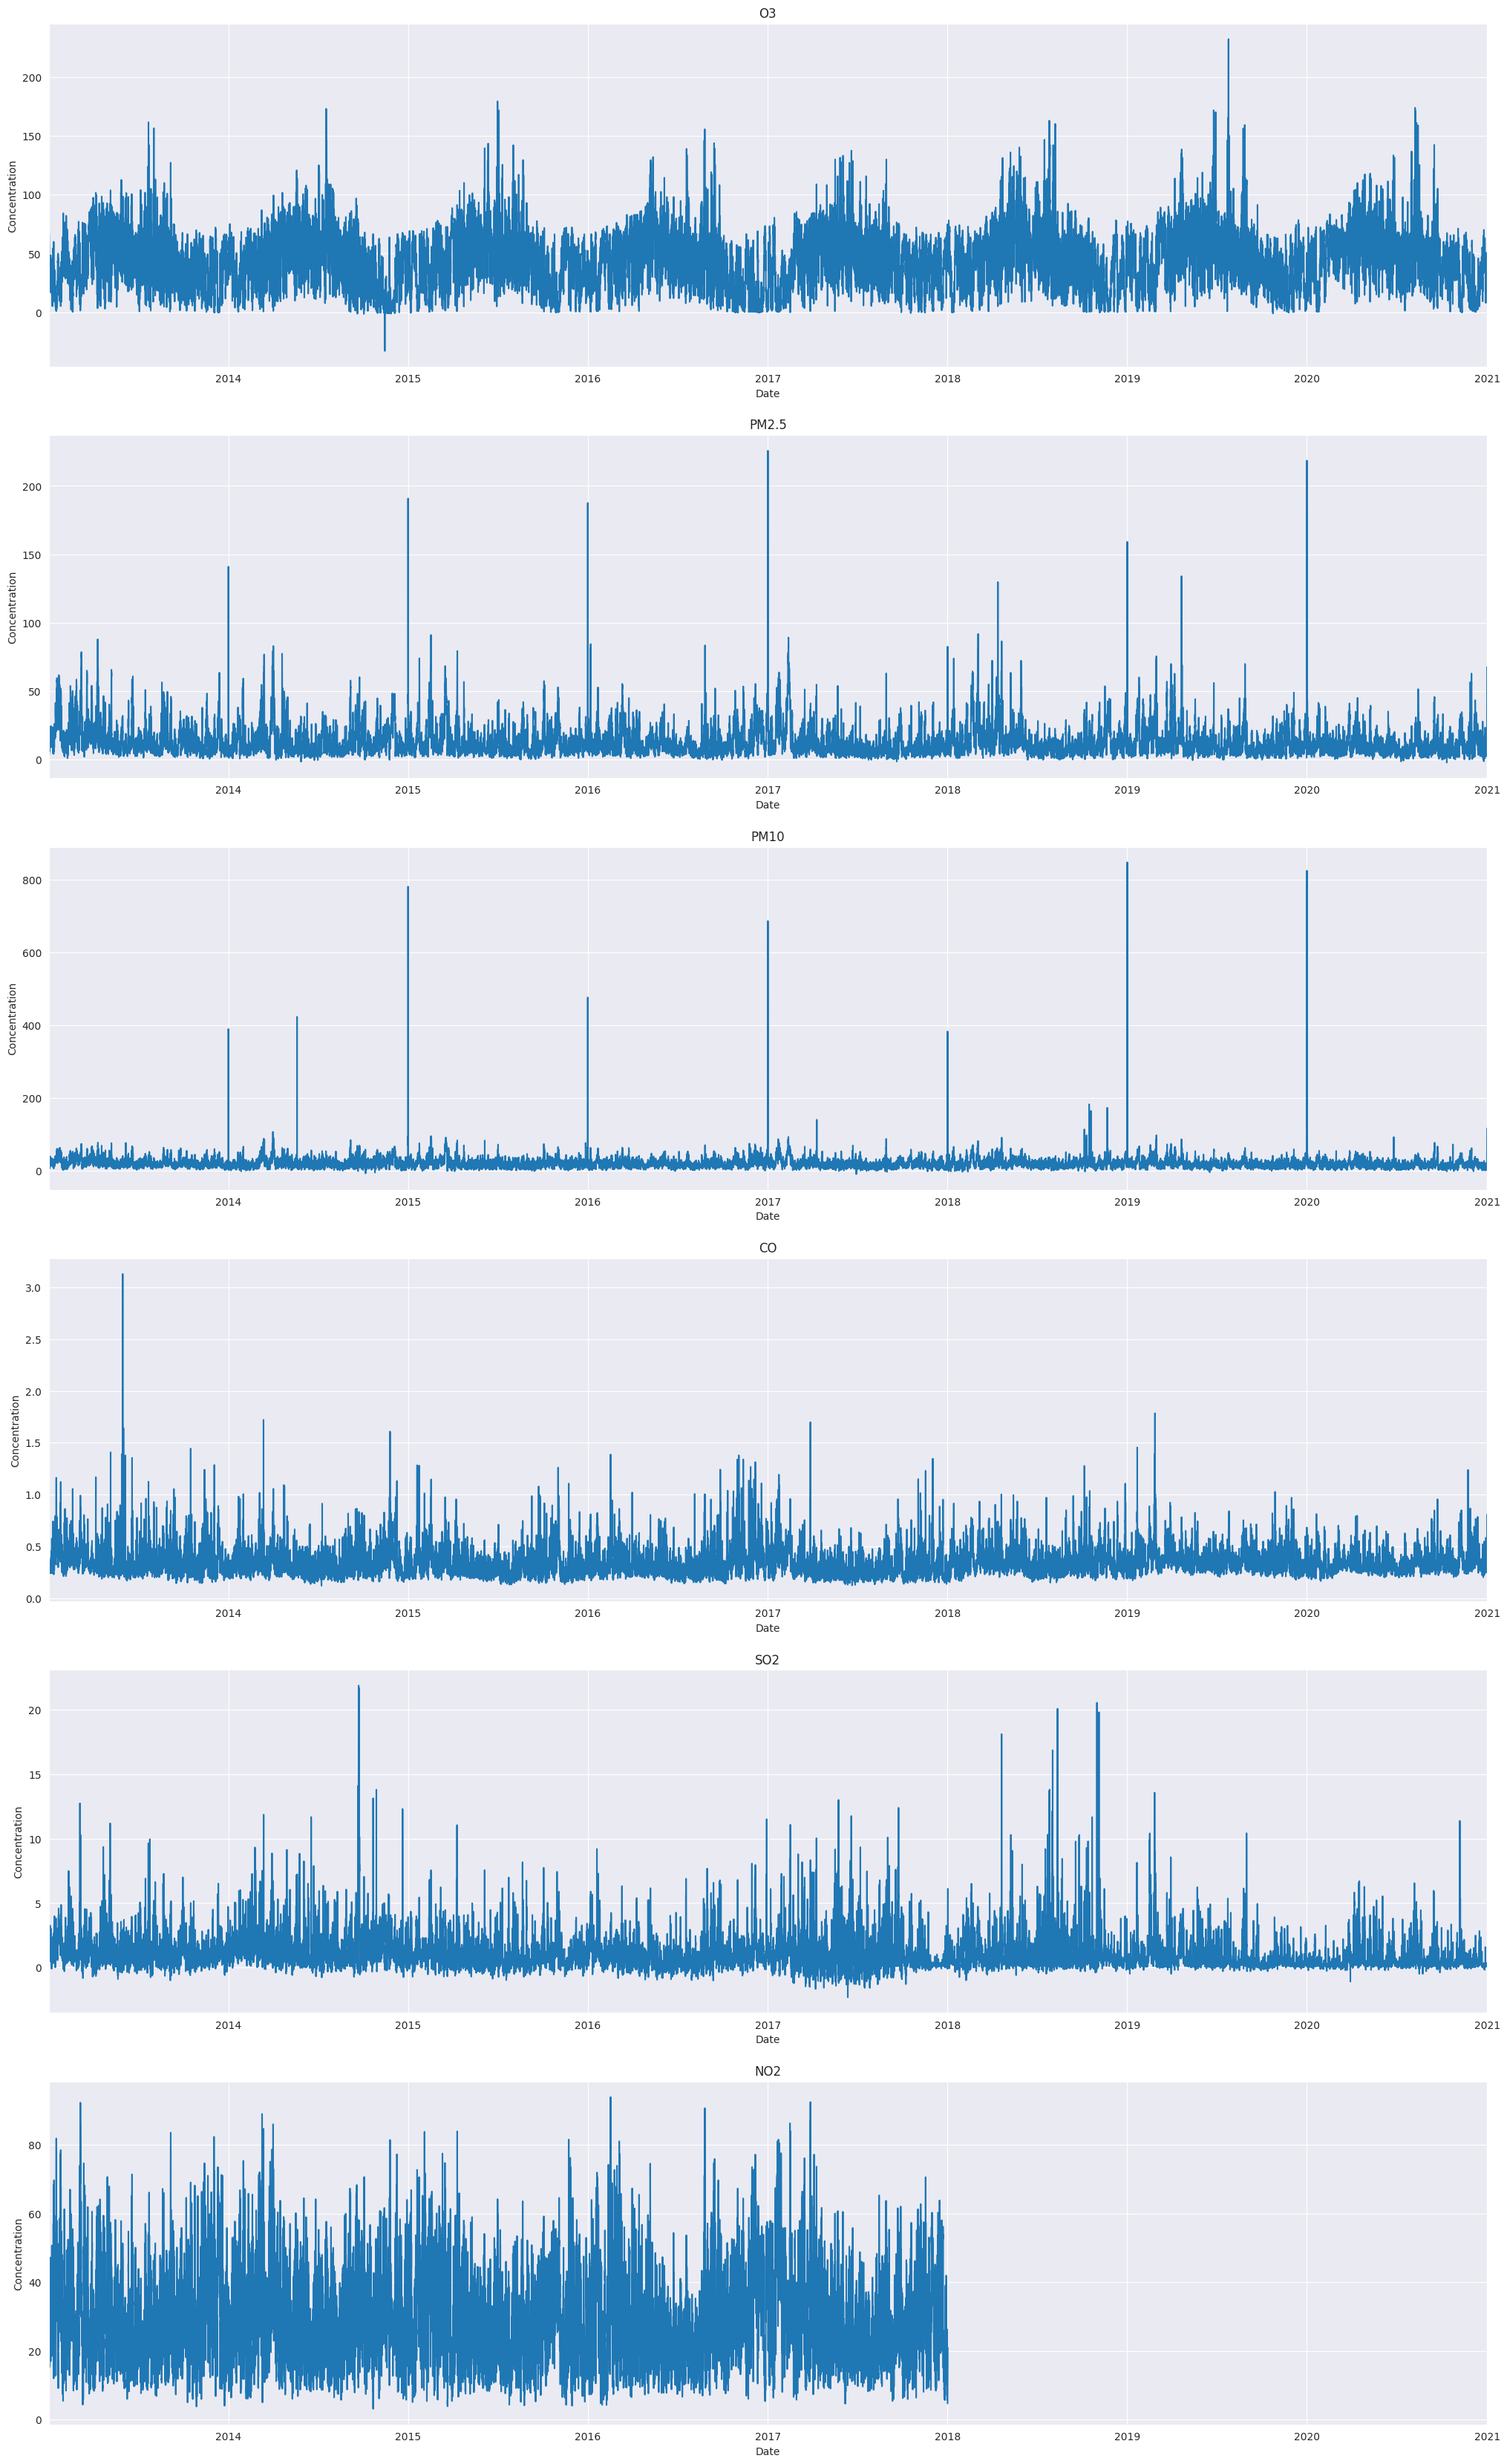

In [65]:
fig, axs = plt.subplots(len(POLLUTANTS_CODES), figsize=(25,7*len(POLLUTANTS_CODES)))
for i in range(len(POLLUTANTS_CODES)):
    df_ts[POLLUTANTS_CODES_NAMES[POLLUTANTS_CODES[i]]].plot(xlabel="Date", ylabel="Concentration", title=POLLUTANTS_CODES_NAMES[POLLUTANTS_CODES[i]], ax = axs[i], c='tab:blue')

## Research: correlation between the concentrations of the pollutants

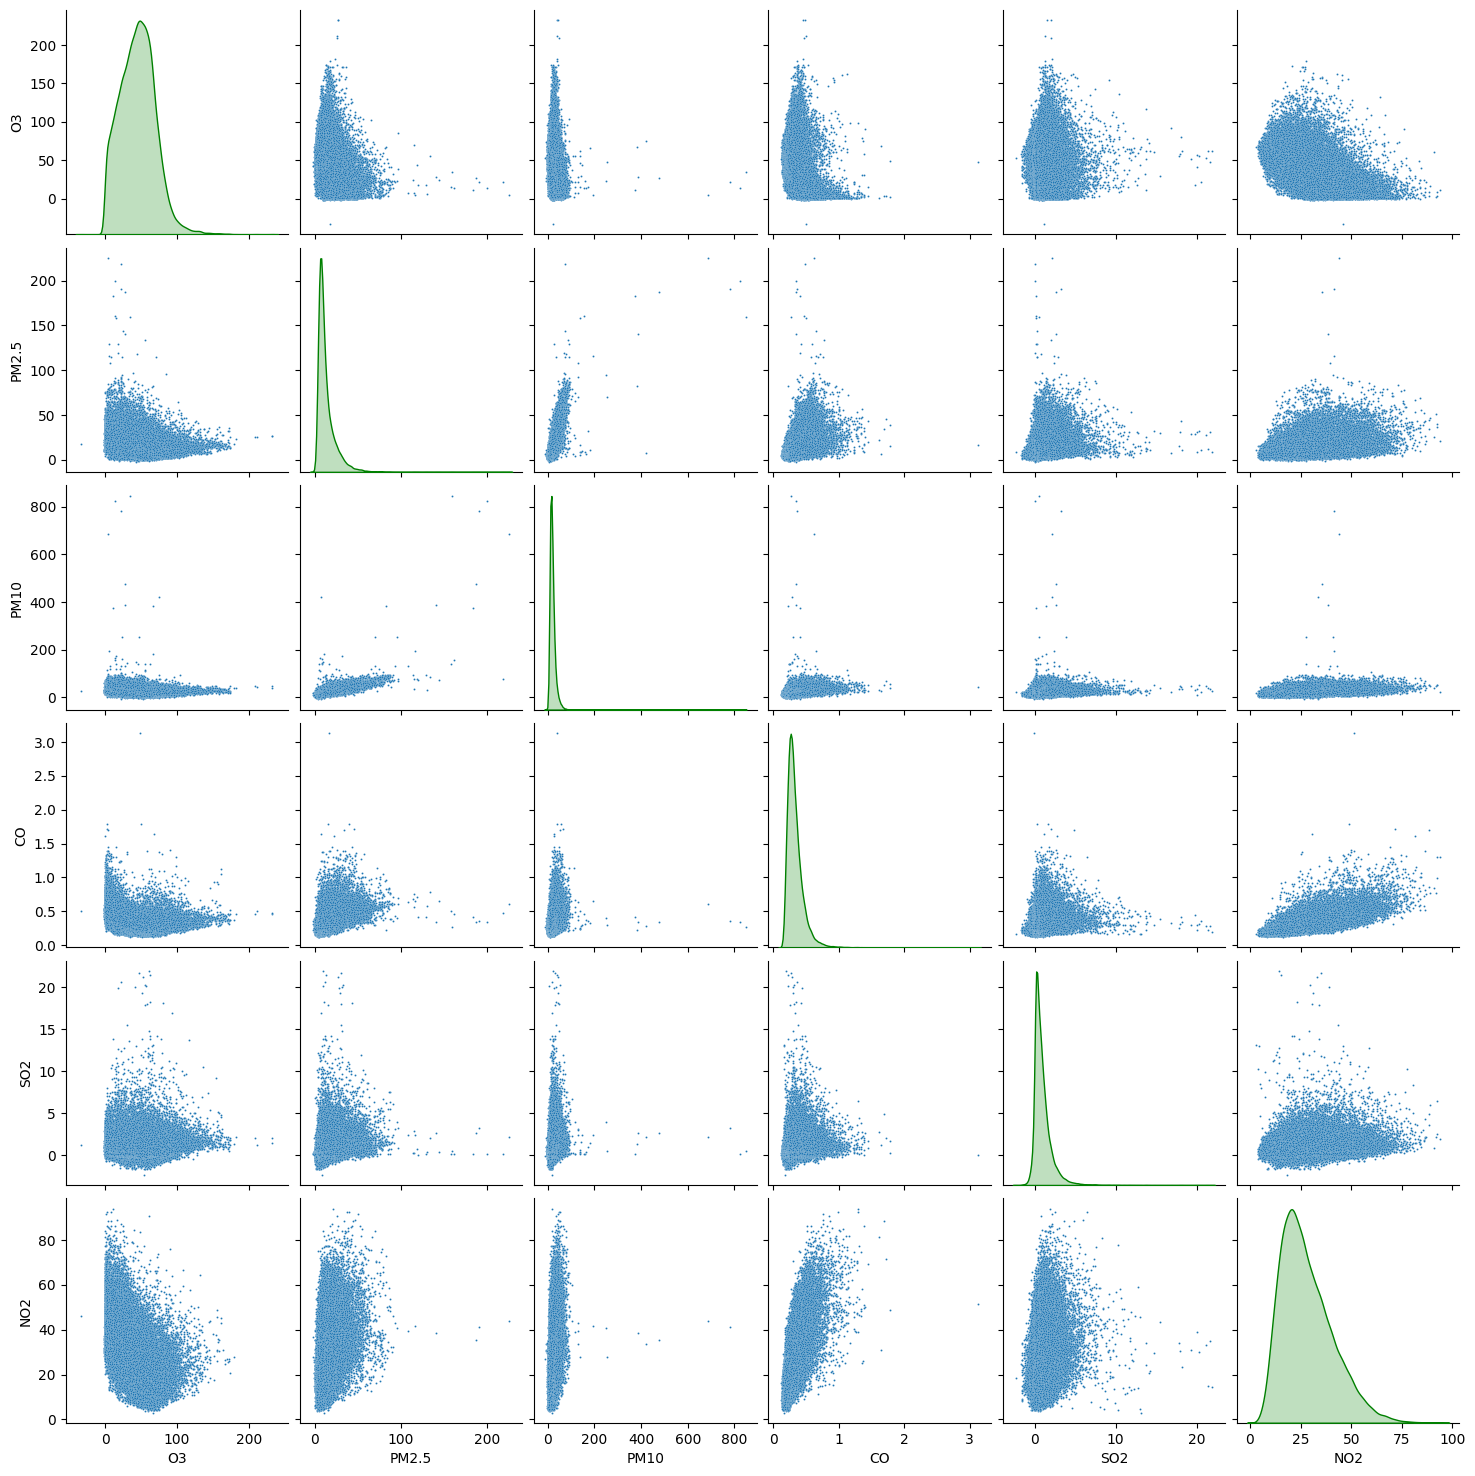

In [60]:
sns.pairplot(df_ts, diag_kind='kde', kind='scatter', plot_kws={"s": 2}, diag_kws={'color':'green'})
#sns.pairplot(df_ts, diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}, "s": 1}, diag_kws={'color':'green'})

## Correlation calculation

<AxesSubplot: >

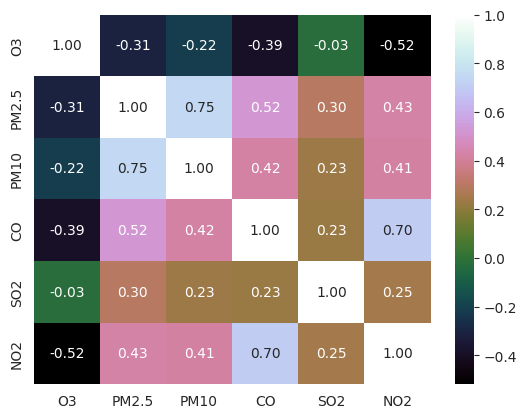

In [80]:
sns.heatmap(df_ts.corr(), annot=True, fmt=".2f", cmap='cubehelix')

## Loading METADATA
## Only 6 required pollutants left in the dataframe.

In [81]:
mdf = pd.read_csv(METADATA_SOURCE_PATH, sep='\t', usecols=METADATA_USE_COLUMNS)
mdf['AirPollutantCode'] = mdf['AirPollutantCode'].apply(lambda x: int(x[x.rfind('/') + 1:]))
mdf['AirPollutantCode']  = pd.to_numeric(mdf['AirPollutantCode'] )
req_pollutant_cond = mdf['AirPollutantCode'].isin(POLLUTANTS_CODES)
mdf = mdf[req_pollutant_cond]
print(f'Lines count: {mdf.shape[0]}')
mdf.head()

Lines count: 32480


,Countrycode,AirQualityStation,AirPollutantCode,Longitude,Latitude,Altitude,AirQualityStationType,AirQualityStationArea
0,AD,STA-AD0942A,1,1.539138,42.509694,1080.0,background,urban
1,AD,STA-AD0942A,5,1.539138,42.509694,1080.0,background,urban
2,AD,STA-AD0942A,7,1.539138,42.509694,1080.0,background,urban
3,AD,STA-AD0942A,8,1.539138,42.509694,1080.0,background,urban
5,AD,STA-AD0942A,10,1.539138,42.509694,1080.0,background,urban


## Filter metadata by country and pollutant if required. Drop AirPollutantCode column if the only pollutant should be considered

In [82]:
if country_code is not None and len(country_code) > 0:
    country_cond = mdf['Countrycode'].__eq__(country_code)
    mdf = mdf[country_cond]
    print(f'Filtered by country: {country_code}. Rest lines count: {mdf.shape[0]}')

Filtered by country: NL. Rest lines count: 591


In [83]:
for i in range(len(POLLUTANTS_CODES)):
    df_list[i] = pd.merge(df_list[i], mdf, how='left', left_on=['Countrycode', 'AirQualityStation'], right_on=['Countrycode', 'AirQualityStation'])
print(df_list[0].columns)
df_list[0].head()

Index(['index', 'Countrycode', 'AirQualityStation', 'Concentration',
       'DatetimeEnd', 'AirPollutantCode', 'Longitude', 'Latitude', 'Altitude',
       'AirQualityStationType', 'AirQualityStationArea'],
      dtype='object')


,index,Countrycode,AirQualityStation,Concentration,DatetimeEnd,AirPollutantCode,Longitude,Latitude,Altitude,AirQualityStationType,AirQualityStationArea
0,0,NL,STA-NL00494,2.9,2013-09-20 00:00:00+01:00,1,4.401389,51.921389,3.0,background,urban
1,0,NL,STA-NL00494,2.9,2013-09-20 00:00:00+01:00,1,4.401389,51.921389,3.0,background,urban
2,0,NL,STA-NL00494,2.9,2013-09-20 00:00:00+01:00,5,4.401389,51.921389,3.0,background,urban
3,0,NL,STA-NL00494,2.9,2013-09-20 00:00:00+01:00,5,4.401389,51.921389,3.0,background,urban
4,0,NL,STA-NL00494,2.9,2013-09-20 00:00:00+01:00,7,4.401389,51.921389,3.0,background,urban


## Dataframe preparation

In [84]:
df_group_station_area_list = list()
for i in range(len(POLLUTANTS_CODES)):
    df_group_station_area_list.append(df_list[i].groupby('AirQualityStationArea')['Concentration'].mean().to_frame())
    df_group_station_area_list[i].rename(columns={'Concentration': POLLUTANTS_CODES_NAMES[POLLUTANTS_CODES[i]]}, inplace=True)

df_ts = reduce(lambda df1, df2: df1.merge(df2, how='outer', left_on=['AirQualityStationArea'], right_on=['AirQualityStationArea']), df_mean_list)
print(df_ts.shape[0])
df_ts.head()

KeyError: 'AirQualityStationArea'

## Research: correlation between the concentrations and station types

In [106]:
fig, axs = plt.subplots(len(POLLUTANTS_CODES), figsize=(25, 7 * len(POLLUTANTS_CODES)))
#fig.subplots_adjust(right=0.75)
for i in range(len(POLLUTANTS_CODES)):
    df_ts[POLLUTANTS_CODES_NAMES[POLLUTANTS_CODES[i]]].plot(xlabel="Date", ylabel="Concentration",
                                                            title=POLLUTANTS_CODES_NAMES[POLLUTANTS_CODES[i]],
                                                            ax=axs[i], c='tab:blue')

## Research: correlation between the concentrations and station areas

## Research: correlation between the station types and station areas